<a href="https://colab.research.google.com/github/Abdollahshomakhar/cifar10-pytorch/blob/main/cifar10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import numpy as np
import time

In [2]:
def _trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    # From timm library, for initializing weights more effectively
    # https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/weight_init.py
    def norm_cdf(x):
        return (1. + math.erf(x / math.sqrt(2.))) / 2.

    with torch.no_grad():
        l = norm_cdf((a - mean) / std)
        u = norm_cdf((b - mean) / std)
        tensor.uniform_(2 * l - 1, 2 * u - 1)
        tensor.erfinv_()
        tensor.mul_(std * math.sqrt(2.))
        tensor.add_(mean)
        tensor.clamp_(min=a, max=b)
        return tensor

def trunc_normal_(tensor, mean=0., std=1., a=-2., b=2.):
    _trunc_normal_(tensor, mean=mean, std=std, a=a, b=b)

In [3]:
class PatchEmbeddings(nn.Module):
    """
    Splits image into patches and embeds them.
    A Conv2d with kernel_size=patch_size and stride=patch_size performs this efficiently.
    """
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention (MHSA) mechanism.
    """
    def __init__(self, embed_dim, num_heads, qkv_bias=False, qk_scale=None, attn_drop_rate=0., proj_drop_rate=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # Combined QKV linear projection
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_rate)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(proj_drop_rate)

    def forward(self, x):
        B, N, C = x.shape # B: batch_size, N: sequence_length, C: embed_dim

        # qkv: (B, N, C*3) -> (B, N, 3, num_heads, head_dim) -> (3, B, num_heads, N, head_dim)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        # Attention: (B, num_heads, N, N)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Weighted sum of values: (B, num_heads, N, head_dim)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class MLP(nn.Module):
    """
    A two-layer Feed-Forward Network with GELU activation and dropout.
    """
    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    """
    One block of the Transformer Encoder.
    Consists of LayerNorm, MHSA, Dropout, Residual Connection,
    LayerNorm, MLP, Dropout, Residual Connection.
    (Pre-normalization is used here, which is common in ViT for better stability)
    """
    def __init__(self, embed_dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(
            embed_dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop_rate=attn_drop_rate, proj_drop_rate=drop_rate)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = MLP(in_features=embed_dim, hidden_features=mlp_hidden_dim,
                       out_features=embed_dim, drop=drop_rate)

    def forward(self, x):
        # Pre-normalization and residual connections
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x




### 3. The Vision Transformer Model

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, num_classes=1000,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True,
                 qk_scale=None, drop_rate=0., attn_drop_rate=0., pos_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_features = self.embed_dim

        self.patch_embed = PatchEmbeddings(
            img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # Learnable Class Token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # Learnable Positional Embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=pos_drop_rate)

        # Transformer Encoder Blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                embed_dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop_rate=drop_rate, attn_drop_rate=attn_drop_rate
            )
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        # Initialize weights
        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def forward_features(self, x):
        B = x.shape[0]

        # Patch embeddings
        x = self.patch_embed(x) # (B, num_patches, embed_dim)

        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1) # (B, num_patches + 1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Pass through transformer blocks
        for blk in self.blocks:
            x = blk(x)

        # Apply final LayerNorm
        x = self.norm(x)

        # Return the [CLS] token's output for classification
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [11]:
IMG_SIZE = 32 # CIFAR-10 images are 32x32
PATCH_SIZE = 4 # Small patches for small images (32/4 = 8x8 patches)
IN_CHANNELS = 3
NUM_CLASSES = 10 # CIFAR-10 has 10 classes
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 5 # You'll need more for better performance
EMBED_DIM = 192 # Smaller embedding dimension for smaller models
DEPTH = 6      # Fewer transformer blocks
NUM_HEADS = 6  # Fewer attention heads

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [27]:
trainset, trainset.data.shape


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomCrop(size=(32, 32), padding=4)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
            ),
 (50000, 32, 32, 3))

In [32]:
images, labels = next(iter(testloader))
print(images.shape, labels.shape)


torch.Size([128, 3, 32, 32]) torch.Size([128])


In [33]:
labels

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6,
        8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7,
        8, 3, 1, 2, 8, 0, 8, 3])

In [13]:
model = VisionTransformer(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    in_channels=IN_CHANNELS,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    depth=DEPTH,
    num_heads=NUM_HEADS,
    mlp_ratio=4.,
    qkv_bias=True,
    drop_rate=0.1,
    attn_drop_rate=0.1,
    pos_drop_rate=0.1
).to(DEVICE)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# --- Training Function ---
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 100 == 0:
            print(f"Epoch: {epoch+1}/{EPOCHS} | Batch: {batch_idx}/{len(trainloader)} | "
                  f"Loss: {running_loss/(batch_idx+1):.4f} | Acc: {100.*correct/total:.2f}%")
    end_time = time.time()
    print(f"Epoch {epoch+1} finished. Time: {end_time - start_time:.2f}s, "
          f"Avg Loss: {running_loss/len(trainloader):.4f}, Train Acc: {100.*correct/total:.2f}%")

# --- Testing Function ---
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f"Test Loss: {test_loss/len(testloader):.4f} | Test Acc: {100.*correct/total:.2f}%")
    return 100.*correct/total

# --- Main Training Loop ---
best_acc = 0
print("\nStarting Training...")
for epoch in range(EPOCHS):
    train(epoch)
    scheduler.step()
    acc = test(epoch)
    if acc > best_acc:
        best_acc = acc
        # torch.save(model.state_dict(), './best_vit_cifar10.pth') # Uncomment to save model
        print(f"New best accuracy: {best_acc:.2f}%")

print(f"\nTraining finished! Best Test Accuracy: {best_acc:.2f}%")


Starting Training...
Epoch: 1/5 | Batch: 0/391 | Loss: 2.3774 | Acc: 9.38%
Epoch: 1/5 | Batch: 100/391 | Loss: 2.0192 | Acc: 23.54%
Epoch: 1/5 | Batch: 200/391 | Loss: 1.9285 | Acc: 26.59%
Epoch: 1/5 | Batch: 300/391 | Loss: 1.8795 | Acc: 28.32%
Epoch 1 finished. Time: 31.77s, Avg Loss: 1.8410, Train Acc: 29.90%
Test Loss: 1.7497 | Test Acc: 35.51%
New best accuracy: 35.51%
Epoch: 2/5 | Batch: 0/391 | Loss: 1.8634 | Acc: 35.16%
Epoch: 2/5 | Batch: 100/391 | Loss: 1.6739 | Acc: 37.47%
Epoch: 2/5 | Batch: 200/391 | Loss: 1.6399 | Acc: 38.86%
Epoch: 2/5 | Batch: 300/391 | Loss: 1.6224 | Acc: 39.68%
Epoch 2 finished. Time: 30.67s, Avg Loss: 1.6011, Train Acc: 40.60%
Test Loss: 1.5289 | Test Acc: 44.89%
New best accuracy: 44.89%
Epoch: 3/5 | Batch: 0/391 | Loss: 1.4333 | Acc: 48.44%
Epoch: 3/5 | Batch: 100/391 | Loss: 1.4613 | Acc: 46.34%
Epoch: 3/5 | Batch: 200/391 | Loss: 1.4502 | Acc: 46.69%
Epoch: 3/5 | Batch: 300/391 | Loss: 1.4442 | Acc: 47.00%
Epoch 3 finished. Time: 30.75s, Avg Los

In [15]:
model.eval()

    # Assuming 'image' is a preprocessed tensor suitable for the model (e.g., (1, 3, 32, 32))
sample_image = torch.randn(1, IN_CHANNELS, IMG_SIZE, IMG_SIZE).to(DEVICE)
with torch.no_grad():
    output = model(sample_image)
    probabilities = torch.softmax(output, dim=1)
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    print(f"Predicted class index: {predicted_class_idx}")

Predicted class index: 9


True label: frog
Predicted label: frog


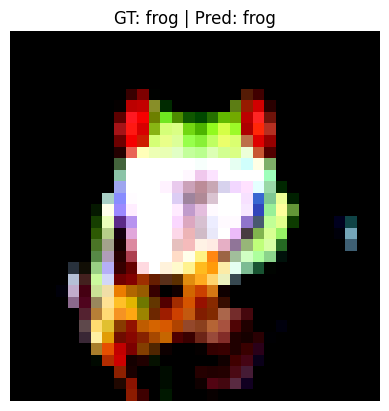

In [39]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# کلاس‌های CIFAR-10
classes = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

model.eval()

# گرفتن یک batch از testloader
images, labels = next(iter(testloader))

# انتخاب یک تصویر (مثلاً اولی)
image = images[102].unsqueeze(0).to(DEVICE)   # (1, 3, 32, 32)
label = labels[102].item()

with torch.no_grad():
    outputs = model(image)
    probs = torch.softmax(outputs, dim=1)
    pred_idx = torch.argmax(probs, dim=1).item()

print(f"True label: {classes[label]}")
print(f"Predicted label: {classes[pred_idx]}")

# برای نمایش تصویر باید نرمال‌سازی رو برگردونیم
img = images[102].cpu()

# اگر transform نرمال‌سازی داشته (مثلاً mean/std)
# این قسمت رو مطابق transform خودت تنظیم کن
img = img * 0.5 + 0.5  # مثال برای mean=0.5 std=0.5
img = img.numpy().transpose((1, 2, 0))

plt.imshow(img)
plt.title(f"GT: {classes[label]} | Pred: {classes[pred_idx]}")
plt.axis('off')
plt.show()
